# IBM Quantum Experience Lab - Lab script

Please use this notebook as a template for the work that you will submit for assessment for this lab exercise.

Student Names: Parth Bhandari
               Sheila Perez 
               Charlie Solomons-Tuke

## Warm up exercise

In [3]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
import numpy as np

In [23]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.measure(qr[0],cr[0])

backend = Aer.get_backend('qasm_simulator')

exponent = np.arange(2,26,1) # 2^25 iterations is as much as I can calulate in a reasonable amound of time.
expectation = []
for s in [2**n for n in exponent]:
    job = execute(circuit, backend, shots=s)
    result=job.result().get_counts(circuit)
    expectation.append((result['0']-result['1'])/(result['0']+result['1']))

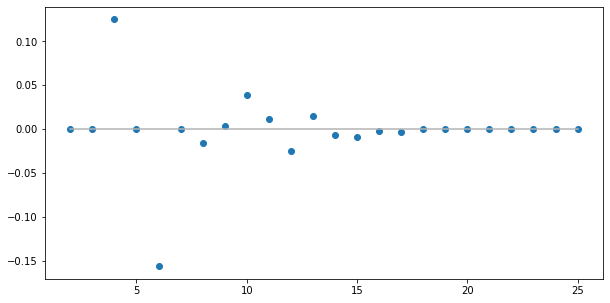

In [24]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.scatter(exponent, expectation)
ax.plot(exponent, exponent*0, c=(0.7,.7,0.7))

## Main exercise